# A) Importing Libraries

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

import splitfolders
import cv2

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

import os

-------------

# B) We are splitting our Dataset into three parts --> Train, Test and Validation

In [13]:
input_folder='/kaggle/input/agricultural-crops-image-classification/Agricultural-crops'
output_folder='/kaggle/working/'

# 80% images for the training set and other 20% images are for train and test (both contains 10%)
split_ratio=(0.8, 0.1, 0.1)

splitfolders.ratio(
     input_folder,
    output=output_folder,
    seed=500,
    ratio=split_ratio,
    group_prefix=None
)

Copying files: 829 files [00:01, 432.26 files/s]


-------------

# C) Defining Parameters

In [14]:
# fix the images size for training
img_size=(224,224)

# It means the model will update it weights after preprocessing 32 images
batch_size=32

-------------

## i) Augmentation for Training Data

In [15]:
train_datagen=ImageDataGenerator(
     preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## ii) Data Augmentation for Test Data (Only rescaling)

#### 1) We have our test and validation dataset we have applied the image data geenration function to rescale the pixel values without any additional augmentation.

#### 2) This ensures the test data remains consistent and is not altered by random transformations.

In [16]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

## iii) Data Augmentation for Validation Data (Only rescaling)

#### 1) We do exactly the same with validation data

In [17]:
valid_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

-------------

# D) Creating three separate folders 

In [18]:
train_dir=os.path.join(output_folder, 'train')

val_dir=os.path.join(output_folder, 'val')

test_dir=os.path.join(output_folder, 'test')

-------------

# E) Loading the images into three separate folders

In [19]:
train_data=train_datagen.flow_from_directory(
     train_dir,
    target_size=img_size,
    batch_size=batch_size,
    # It is a multiclass classification problem that's why we write class_mode='categorical'
    class_mode='categorical'
)


test_data=test_datagen.flow_from_directory(
     test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


valid_data=valid_datagen.flow_from_directory(
     val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 652 images belonging to 30 classes.
Found 105 images belonging to 30 classes.
Found 72 images belonging to 30 classes.


-------------

# F) Visualizing the sample images

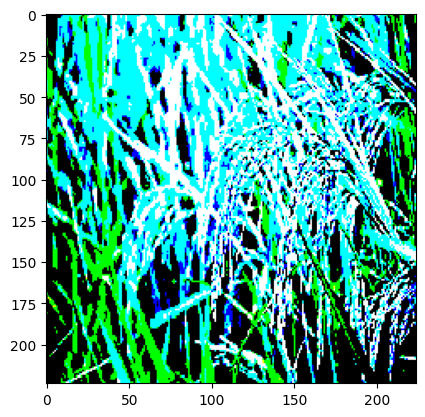

In [23]:
import random

# Get a batch size of images and labels
images, labels=next(valid_data)

# Select a random image from the batch
idx=random.randint(0, images.shape[0] - 1)

# Display the image
plt.imshow(images[idx])
plt.show()

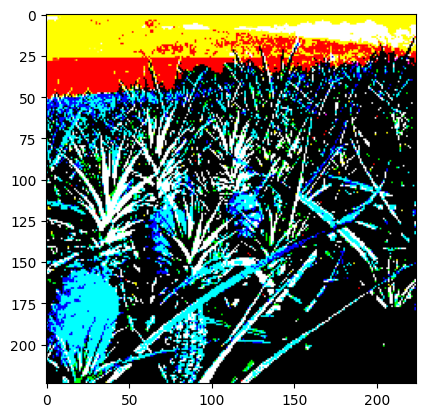

In [25]:
# Get a batch size of images and labels
images, labels=next(valid_data)

# Select a random image from the batch
idx=random.randint(0, images.shape[0] - 1)

# Display the image
plt.imshow(images[idx])
plt.show()

-------------

# G) Loading our Pre-trained Model

In [26]:
from keras.applications.resnet import ResNet50

base_model=ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3) )


# Freeze the convolutional base, it means the wights of these layers will not be updated during training
# It helps to leverage the features learned from the image n dataset without altering them
base_model.trainable=False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## i) Adding extra stack layers

In [28]:
model=models.Sequential([
    base_model,
    # It is used to reduce overfitting and the number of parameters
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    # Softmax returns the probability of different values, where the sum of all the values leads to 1
    layers.Dense(30, activation='softmax')
])

## ii) Compiling the Model

In [32]:
model.compile(optimizer='adam', # optimizer is responsible for updating the model's weights during training to minimize the loss function
             loss='categorical_crossentropy', # less our loss our model will be better
             metrics=['accuracy'])

## iii) Fitting the Model

In [33]:
model.fit(train_data, epochs=25, validation_data=valid_data)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727713260.783759    2081 service.cc:145] XLA service 0x7abd6804b860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727713260.783860    2081 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/21 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.0234 - loss: 4.8491 

I0000 00:00:1727713268.396585    2081 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 952ms/step - accuracy: 0.0661 - loss: 4.0115 - val_accuracy: 0.3056 - val_loss: 2.7054
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step - accuracy: 0.2056 - loss: 2.9053 - val_accuracy: 0.3472 - val_loss: 2.3300
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step - accuracy: 0.2588 - loss: 2.4598 - val_accuracy: 0.5278 - val_loss: 1.8286
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.3584 - loss: 2.1754 - val_accuracy: 0.5833 - val_loss: 1.5397
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.4627 - loss: 1.9116 - val_accuracy: 0.6528 - val_loss: 1.4009
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.5216 - loss: 1.6385 - val_accuracy: 0.7083 - val_loss: 1.2285
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.5841 - loss: 1.4354 - val_accuracy: 0.7222 - val_loss: 1.1608
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.5901 - loss: 1.3515 - val_accuracy: 0.722

## iv) Model Evaluation

In [34]:
test_loss, test_accuracy=model.evaluate(test_data)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7565 - loss: 0.8227  
Test Accuracy: 77.14%


#### Our Model Accuracy is 77%, which is Good.

-------------

# H) Prediction 

#### Giving all the class names and putting into a dictionary

In [38]:
class_names={0:'Cherry' ,1:'Coffee-plant' ,2:'Cucumber' ,3:'Fox_nut(Makhana)' ,4:'Lemon' ,5:'Olive-tree' ,
             6:'Pearl_millet(bajra' ,7:'Tobacco-plant' ,8:'almond' ,9:'banana' ,10:'cardamom' ,
             11:'chilli' ,12:'clove' ,13:'coconut' ,14:'cotton' ,15:'gram' ,
             16:'jowar' ,17:'jute' ,18:'maize' ,19:'mustard-oil' ,20:'papaya' ,
             21:'pineapple' ,22:'rice' ,23:'soyabean' ,24:'sugercane' ,25:'sunflower' ,
             26:'tea' ,27:'tomato' ,28:'vigna-radiati(Mung)' ,29:'wheat'}

## Prediction Function

In [43]:
def predict_img(image, model):
    
    test_img=cv2.imread(image)
    plt.imshow(test_img)
    
    test_img=cv2.resize(test_img, (224,224))
    test_img=np.expand_dims(test_img, axis=0)
    
    result=model.predict(test_img)
    
    r=np.argmax(result)
    print(class_names[r])

### Test case 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Coffee-plant


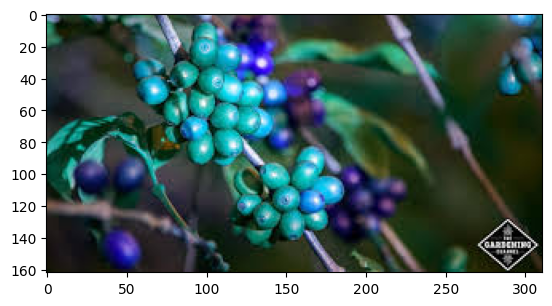

In [47]:
predict_img('/kaggle/working/test/Coffee-plant/images64.jpg',model)

### Test case 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
sunflower


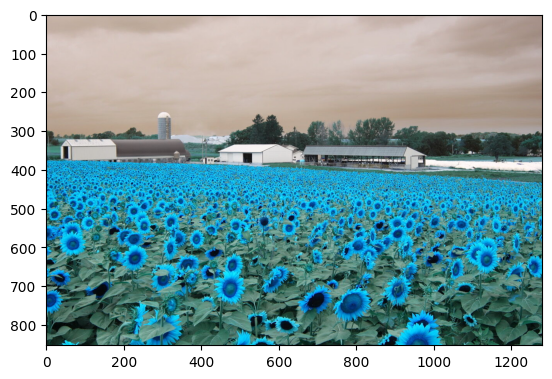

In [48]:
predict_img('/kaggle/working/test/sunflower/image (30).jpg', model)

## I) Saving the Model

In [49]:
model.save('CropModel.keras')

-------------